## Example of multiclass classification with a MLP

This example use the the Iris classification dataset to demonstrate an MLP for multiclass classification.

The dataset can be found at:

- [iris Dataset (csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv)
- [Iris Dataset Description](https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.names)


In [1]:
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import random_split

class CSVDataset(Dataset):
    def __init__(self, path):
        df = read_csv(path, header=None)
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])


In [2]:
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
    
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [4]:
from torch.utils.data import DataLoader

dataset = CSVDataset('https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv')
train, test = dataset.get_splits()
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

In [11]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

model = MLP(4)
# define the optimization
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []
# enumerate epochs
for epoch in range(200):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        losses.append(loss)

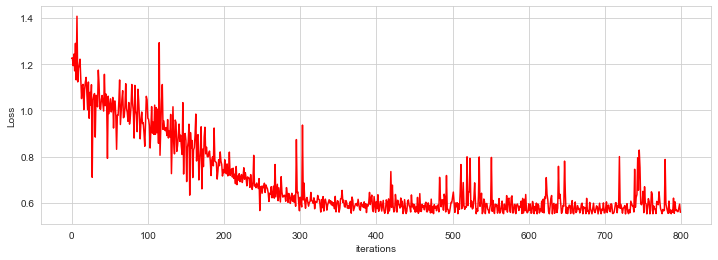

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style(style = 'whitegrid')
plt.rcParams["patch.force_edgecolor"] = True

plt.figure(figsize = (12,4))
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

In [6]:
from numpy import vstack
from sklearn.metrics import accuracy_score

predictions, actuals = list(), list()
for i, (inputs, targets) in enumerate(test_dl):
    # evaluate the model on the test set
    yhat = model(inputs)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    actual = targets.numpy()
    # convert to class labels
    yhat = argmax(yhat, axis=1)
    # reshape for stacking
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))
    # store
    predictions.append(yhat)
    actuals.append(actual)
predictions, actuals = vstack(predictions), vstack(actuals)
# calculate accuracy
acc = accuracy_score(actuals, predictions)
print('Accuracy: %.3f' % acc)

Accuracy: 0.940


Source:

- https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/